# Post-stack inversion of Volve data Volve 数据的叠后反演

**Author: M. Ravasi, KAUST**


Welcome to the **Matrix-free inverse problems with PyLops** tutorial!

欢迎来到 **使用 PyLops 处理无矩阵逆问题** 教程！

The aim of this tutorial is to:

本教程的目的是：

- Utilize PyLops to perform seismic post-stack inversion of the Volve dataset;
- Familiarize with novel optimization techniques that can enhance the quality of your inversion using L1 regularization;
- Get introduced to _PyProximal_, PyLops little sister library to perform even more advanced optimization by means of so-called proximal algorithms.

- 利用 PyLops 对 Volve 数据集执行地震叠后反演；
- 熟悉新颖的优化技术，利用 L1 正则化提高反演质量；
- 介绍 _PyProximal_，这是 PyLops 的姊妹库，通过所谓的近端算法执行更高级的优化。


Post-stack seismic modelling is the process of constructing seismic post-stack data from an acoustic impedance profile as function of time (or depth). From a mathematical point of view, this can be easily achieved using the following forward model:

叠后地震建模是从作为时间（或深度）函数的声阻抗剖面构建地震叠后数据的过程。从数学角度来看，这可以使用以下正演模型轻松实现：

$$
d(t, \theta=0) =  \frac{1}{2} w(t) * \frac{dln(m(t))}{dt}
$$

where $m(t)$ is the acoustic impedance profile and $w(t)$ is the time domain seismic wavelet.

其中 $m(t)$ 是声阻抗剖面，$w(t)$ 是时域地震子波。

In compact form:

紧凑形式：

$$
\mathbf{d}= \mathbf{W} \mathbf{D} \mathbf{m}
$$

The associated inverse problems we wish to solve can written as:

我们希望解决的相关逆问题可以写成：

- Least-squares 最小二乘

  $$
  J = arg min_{\mathbf{m}} ||\mathbf{d} - \mathbf{W} \mathbf{D} \mathbf{m}||_2 + \epsilon_1||\nabla_{x,y}\mathbf{m}||_2
  $$

- L1-regularized L1 正则化

  $$
  J = arg min_{\mathbf{m}} ||\mathbf{d} - \mathbf{W} \mathbf{D} \mathbf{m}||_2 + \epsilon_1||\nabla_{x,y}\mathbf{m}||_2 + \epsilon_2||\mathbf{D}\mathbf{m}||_1
  $$

- TV-regularized TV 正则化
  $$
  J = arg min_{\mathbf{m}} ||\mathbf{d} - \mathbf{W} \mathbf{D} \mathbf{m}||_2 + \epsilon TV(\mathbf{m})
  $$

where $\nabla_{x,y}$ is the Laplacian along the x,y plane. 其中 $\nabla_{x,y}$ 是沿 x,y 平面的拉普拉斯算子。


## Data retrieval 数据检索


In order to be able to run this notebook we need to first make sure we have access to the Volve dataset.

为了能够运行此笔记本，我们需要首先确保可以访问 Volve 数据集。

We cannot provide the data directly given its size, but the Volve data is hosted on a Azure Blob storage so it is very easy to download it using the Azure CLI (https://github.com/Azure/azure-cli or `pip install azure-cli` would do).

由于数据量很大，我们无法直接提供数据，但 Volve 数据托管在 Azure Blob 存储上，因此使用 Azure CLI（https://github.com/Azure/azure-cli 或 `pip install azure-cli` 即可）下载非常容易。


First of all let's investigate what is present in the `Seismic` directory

首先，让我们调查一下 `Seismic` 目录中有什么。


In [2]:
print("hello world")

hello world


In [3]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops pyproximal azure-cli scooby

In [4]:
#!az storage blob list --account-name datavillagesa --container-name volve --prefix Seismic/ --sas-token "$YOURTOKEN" > ../data/seismicinversion/list_seismic.txt

In [5]:
#!head -n 60 data/list_seismic.txt

where you will need to substitute `$YOURTOKEN` with your personal token. To get a token, simply register at https://data.equinor.com/authenticate and find the token in the red text in the Usage section. Ensure to copy everything from `?sv=` to `=rl` in place of `$YOURTOKEN`.

其中你需要将 `$YOURTOKEN` 替换为你个人的令牌。要获取令牌，只需在 https://data.equinor.com/authenticate 注册，并在 Usage 部分的红色文本中找到令牌。确保复制从 `?sv=` 到 `=rl` 的所有内容来替换 `$YOURTOKEN`。

We can now download the file of interest.

现在我们可以下载感兴趣的文件了。


In [6]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA
#!az storage blob download --account-name datavillagesa --container-name volve --name Seismic/ST10010/Stacks/ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy --file ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy --sas-token "$YOURTOKEN"
#!mv ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy ../data/seismicinversion

In [7]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA
#!az storage blob download --account-name datavillagesa --container-name volve --name Seismic/ST10010/Velocities/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy --file ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy --sas-token "$YOURTOKEN"
#!mv ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy ../data/seismicinversion

Once the data is downloaded on your machine you are ready for the fun part of this notebook. More specifically, we will perform the following step:

一旦数据下载到你的机器上，你就准备好开始本笔记本的有趣部分了。具体来说，我们将执行以下步骤：

- Data and velocity model are read from SEG-Y file using segyio (note that for the Volve data we will have to deal with irregular geometry);
- Velocity model is resampled to the data grid (both time and spatial sampling) and scaled to become the background AI for inversion;
- Absolute inversion is applied by means of `pylops.avo.poststack.PoststackInversion`;
- TV regularized inversion is performed using `PyProximal`.

- 使用 segyio 从 SEG-Y 文件读取数据和速度模型（注意，对于 Volve 数据，我们将不得不处理不规则的几何形状）；
- 将速度模型重采样到数据网格（包括时间和空间采样），并缩放以成为反演的背景声阻抗（AI）；
- 通过 `pylops.avo.poststack.PoststackInversion` 应用绝对反演；
- 使用 `PyProximal` 执行 TV 正则化反演。


## Data loading 数据加载


Let's first import all the libraries we need.

让我们首先导入我们需要的所有库。


In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import time

import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
import pylops
import pyzgy

# import segyio # 可以注释掉 segyio，除非你的速度模型还是 segy 格式
from pylops.avo.poststack import PoststackInversion, PoststackLinearModelling
from pylops.basicoperators import Gradient
from pyproximal import ProxOperator
from pyproximal.optimization.primal import LinearizedADMM
from pyproximal.optimization.primaldual import PrimalDual
from pyproximal.proximal import L2, L21
from scipy.interpolate import RegularGridInterpolator

cp.cuda.Device(device=0).use()
# 修复 OMP: Error #15 冲突
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

c:\Users\WangQinZhuo\miniconda3\envs\transform2021_devito\lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
c:\Users\WangQinZhuo\miniconda3\envs\transform2021_devito\lib\site-packages\openzgy\impl\file.py:53: UserWarning: seismic store access is not available: No module named 'sdglue'
  warnings.warn("seismic store access is not available: " + str(ex))


And define some of the input parameters we will use later (refer to the following for a more detailed description of the types of inversion).

并定义我们稍后将使用的一些输入参数（有关反演类型的更详细描述，请参阅下文）。


In [9]:
# Data
itmin = 600  # index of first time/depth sample in data used in colored inversion
itmax = 800  # index of last time/depth sample in data used in colored inversion

# Subsampling (can save file at the end only without subsampling)
jt = 1
jil = 2
jxl = 2

# Wavelet estimation
nt_wav = 21  # number of samples of statistical wavelet
nfft = 512  # number of samples of FFT

# Trace-by-Trace Inversion
epsI_tt = 1e-3  # damping

# Spatially simultaneous
niter_sr = 3  # number of iterations of lsqr
epsI_sr = 1e-4  # damping
epsR_sr = 1e2  # spatial regularization

# Blocky simultaneous
niter_out_b = 3  # number of outer loop iterations
niter_in_b = 1  # number of inner loop iterations
niter_b = 10  # number of iterations of lsqr
mu_b = 1e-1  # damping for data term
epsI_b = 1e-4  # damping
epsR_b = 0.1  # spatial regularization
epsRL1_b = 1.0  # blocky regularization

Let's now read the Volve data.

现在让我们读取 Volve 数据。

Note that we add the `ignore_geometry=True` parameter when we open the file. As we will see the geometry in this file is not regular, so we cannot rely on the inner working of segyio to get our data into a 3d numpy.

注意，我们在打开文件时添加了 `ignore_geometry=True` 参数。正如我们将看到的，此文件中的几何形状是不规则的，因此我们不能依赖 segyio 的内部工作机制将数据放入 3d numpy 数组中。

We thus need to read all ILs, XLs and traces and reorganize them ourselves into a regular grid. No worries, numpy will do most of the hard work.

因此，我们需要读取所有的 IL（主测线）、XL（联络测线）和 traces（地震道），并将它们自己重新组织成规则网格。别担心，numpy 会完成大部分繁重的工作。


In [10]:
# segyfile = 'data/ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy'
# f = segyio.open(segyfile, ignore_geometry=True)

# traces = segyio.collect(f.trace)[:]
# traces = traces[:, itmin:itmax]
# ntraces, nt = traces.shape

# t = f.samples[itmin:itmax]
# il = f.attributes(segyio.TraceField.INLINE_3D)[:]
# xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

# # Define regular IL and XL axes
# il_unique = np.unique(il)
# xl_unique = np.unique(xl)

# il_min, il_max = min(il_unique), max(il_unique)
# xl_min, xl_max = min(xl_unique), max(xl_unique)

# dt = t[1] - t[0]
# dil = min(np.unique(np.diff(il_unique)))
# dxl = min(np.unique(np.diff(xl_unique)))

# ilines = np.arange(il_min, il_max + dil, dil)
# xlines = np.arange(xl_min, xl_max + dxl, dxl)
# nil, nxl = ilines.size, xlines.size

# ilgrid, xlgrid = np.meshgrid(np.arange(nil),
#                              np.arange(nxl),
#                              indexing='ij')

# # Look-up table
# traces_indeces = np.full((nil, nxl), np.nan)
# iils = (il - il_min) // dil
# ixls = (xl - xl_min) // dxl
# traces_indeces[iils, ixls] = np.arange(ntraces)
# traces_available = np.logical_not(np.isnan(traces_indeces))

# # Reorganize traces in regular grid
# d = np.zeros((nil, nxl, nt))
# d[ilgrid.ravel()[traces_available.ravel()],
#   xlgrid.ravel()[traces_available.ravel()]] = traces

# # Subsample
# d = d[::jil, ::jxl, ::jt]
# ilines = ilines[::jil]
# xlines = xlines[::jxl]
# t = t[::jt]
# nil, nxl, nt = len(ilines), len(xlines), len(t)

# # Display data
# plt.figure(figsize=(12, 6))
# plt.imshow(d[nil//2].T, cmap='RdYlBu', vmin=-5, vmax=5,
#            extent=(xlines[0], xlines[-1], t[-1], t[0]))
# plt.title('Seismic data - section')
# plt.colorbar()
# plt.axis('tight')

In [11]:
# 定义 ZGY 文件路径 (请修改为你自己的文件路径)
zgyfile = "C:\\Users\\WangQinZhuo\\Program\\xihu_workflow\\data\\obn-yuan.zgy"

# 使用 pyzgy 打开文件
with pyzgy.open(zgyfile) as f:
    # 1. 获取几何信息
    # pyzgy 直接提供了规则的几何轴
    ilines = f.ilines
    xlines = f.xlines
    # 修正：应用时间范围截取 (itmin:itmax)
    t = f.samples[itmin:itmax]

    # 获取原始维度
    nil_raw, nxl_raw, nt_raw = f.n_ilines, f.n_xlines, f.n_samples

    # 获取采样间隔 (用于后续计算或绘图)
    dt = f.zinc
    dil = f.annotinc[0]  # Inline 间隔
    dxl = f.annotinc[1]  # Crossline 间隔

    # 2. 应用降采样 (Subsampling)
    # 更新几何轴
    ilines_sub = ilines[::jil]
    xlines_sub = xlines[::jxl]
    # 修正：在截取后的时间轴上应用降采样
    t_sub = t[::jt]

    # 更新维度
    nil, nxl, nt = len(ilines_sub), len(xlines_sub), len(t_sub)

    print(f"Data dimensions after subsampling: il={nil}, xl={nxl}, t={nt}")

    # 3. 读取数据
    # 为了节省内存，我们逐个 Inline 读取并立即进行 Crossline 和 Time 的降采样
    # f.iline[il] 返回该 Inline 的二维切片 (n_xlines, n_samples)

    d_list = []
    for il in ilines_sub:
        # 读取指定的 Inline (pyzgy 会自动处理解压)
        # 注意：f.iline 使用的是 Inline 编号作为索引，而不是 0,1,2... 的下标
        inline_data = f.iline[il]

        # 对 Crossline 和 Time 维度进行切片降采样
        # 修正：同时应用时间截取 (itmin:itmax) 和降采样 (::jt)
        d_list.append(inline_data[::jxl, itmin:itmax:jt])

    # 将列表堆叠成 3D numpy 数组 (nil, nxl, nt)
    d = np.stack(d_list, axis=0)

# 更新全局变量 t 以匹配后续代码
t = t_sub

# 此时 d 已经是 (nil, nxl, nt) 的形状，且 ilines, xlines, t 也已更新
# 后续的绘图和反演代码可以直接使用这些变量

Data dimensions after subsampling: il=358, xl=628, t=200


In [ ]:
# Display data
plt.figure(figsize=(12, 6))
plt.imshow(d[nil // 2].T, cmap="seismic", extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title("Seismic data - section")
plt.colorbar()
plt.axis("tight")

Setting Backend To: AvailableBackends.numpy
GemPy Extent: [np.int32(205), np.int32(920), np.int32(414), np.int32(1669), np.float64(1200.0), np.float64(1598.0)]
GemPy Coarse Resolution: [50, 50, 50]
Target Seismic Resolution: (358, 628, 200)
Structural Frame elements: ['Reservoir_Top', 'Basement_Top', 'basement']
Setting Backend To: AvailableBackends.numpy


c:\Users\WangQinZhuo\miniconda3\envs\transform2021_devito\lib\site-packages\gempy_engine\core\data\transforms.py:215: RuntimeWarning: Interpolation is being done with the default transform. If you do not know what you are doing you should probably call GeoModel.update_transform() first.
  warnings.warn(
c:\Users\WangQinZhuo\miniconda3\envs\transform2021_devito\lib\site-packages\gempy_engine\modules\activator\_soft_segment.py:95: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + bt.t.exp(x))


Using sequential processing for 2 surfaces
Upscaled Velocity Model Shape: (358, 628, 200)


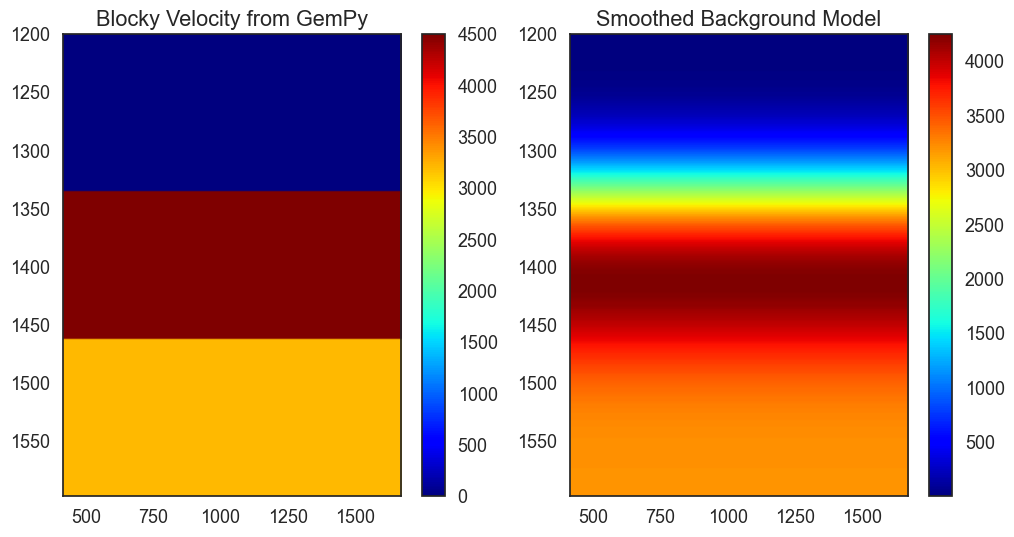

Generated AI shape: (358, 628, 200), Data shape: (358, 628, 200)


In [ ]:
# 假设你已经运行了读取地震数据的代码，变量 d, ilines, xlines, t (或 z) 已经存在
# d 的形状是 (nil, nxl, nt)

import gempy as gp
import numpy as np
from scipy.ndimage import zoom, gaussian_filter
import os

# 1. 定义 GemPy 模型范围 (Extent) 和分辨率
# 使用 simple_fault_model 的原始范围 [0, 2000, 0, 2000, 0, 750]
gempy_extent = [0, 2000, 0, 2000, 0, 750]
# 使用中等分辨率进行计算
gempy_resolution = [50, 50, 50]

print(f"GemPy Extent: {gempy_extent}")
print(f"GemPy Resolution: {gempy_resolution}")

# 2. 创建 GeoModel 并导入数据
# 使用绝对路径指向 gempy 库中的示例文件
# 注意：这里假设文件位于 gempy 库的根目录下，根据你的环境可能需要调整
path_root = r"c:\Users\WangQinZhuo\miniconda3\envs\transform2021_devito\Lib\site-packages\gempy"
path_or = os.path.join(path_root, "simple_fault_model_orientations.csv")
path_pts = os.path.join(path_root, "simple_fault_model_points.csv")

# 检查文件是否存在
if not os.path.exists(path_or):
    print(f"Warning: File not found: {path_or}")
if not os.path.exists(path_pts):
    print(f"Warning: File not found: {path_pts}")

geo_model = gp.create_geomodel(
    project_name='Seismic_Velocity_Model_From_CSV',
    extent=gempy_extent,
    resolution=gempy_resolution,
    refinement=0,
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations=path_or,
        path_to_surface_points=path_pts
    )
)

# 3. 配置地层堆栈 (Stack)
# 映射断层和地层序列
gp.map_stack_to_surfaces(
    gempy_model=geo_model,
    mapping_object={
        "Fault_Series": 'Main_Fault',
        "Strat_Series": ('Sandstone_2', 'Siltstone', 'Shale', 'Sandstone_1')
    }
)

# 将 Fault_Series 标记为断层
gp.set_is_fault(
    frame=geo_model.structural_frame,
    fault_groups=['Fault_Series']
)

print("Structural Frame elements:", geo_model.structural_frame.elements_names)

# 4. 计算地质模型
sol = gp.compute_model(geo_model)

# 获取岩性 ID 块
lith_block_gempy = sol.raw_arrays.lith_block.reshape(gempy_resolution)

# 5. 将岩性 ID 映射为速度
# 简单的基于 ID 的映射。ID 通常对应于地层在 stack 中的顺序。
# 我们可以简单地使用线性映射，或者尝试根据名称映射（如果知道 ID 对应关系）。
# 这里使用简单的线性映射生成速度差异。
# 假设 ID 范围是 0 到 N
velocity_model_gempy = 2000.0 + lith_block_gempy * 500.0

# 6. 将 GemPy 模型放大/重采样到地震数据网格
# 注意：这里我们将 GemPy 模型的物理空间 [0,2000] 强制拉伸到地震数据的物理空间
target_shape = (nil, nxl, nt)

# 计算缩放因子
zoom_factors = [
    target_shape[0] / gempy_resolution[0],
    target_shape[1] / gempy_resolution[1],
    target_shape[2] / gempy_resolution[2]
]

# 使用最近邻插值 (order=0) 保持层位边界清晰，放大回原始尺寸
velocity_model = zoom(velocity_model_gempy, zoom_factors, order=0)

# 修正由于浮点数计算可能导致的 1 像素尺寸误差
if velocity_model.shape != target_shape:
    temp_v = np.zeros(target_shape, dtype=np.float32)
    s0 = min(velocity_model.shape[0], target_shape[0])
    s1 = min(velocity_model.shape[1], target_shape[1])
    s2 = min(velocity_model.shape[2], target_shape[2])
    temp_v[:s0, :s1, :s2] = velocity_model[:s0, :s1, :s2]
    velocity_model = temp_v

print(f"Upscaled Velocity Model Shape: {velocity_model.shape}")

# 7. 平滑处理 (Smoothing) 生成背景模型
sigma = (5, 5, 20) # (Inline, Crossline, Time)
v_background = gaussian_filter(velocity_model, sigma=sigma)

# 可视化检查
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(velocity_model[nil//2].T, cmap='jet', aspect='auto', extent=[xlines[0], xlines[-1], t[-1], t[0]])
plt.title("Blocky Velocity from GemPy (Simple Fault)")
plt.colorbar()

plt.subplot(122)
plt.imshow(v_background[nil//2].T, cmap='jet', aspect='auto', extent=[xlines[0], xlines[-1], t[-1], t[0]])
plt.title("Smoothed Background Model")
plt.colorbar()
plt.show()

# 8. 替换原有变量供后续反演使用
density = 310 * (v_background**0.25)
aiinterp = v_background * density

print(f"Generated AI shape: {aiinterp.shape}, Data shape: {d.shape}")

We read also the migration velocity model. In this case, the SEG-Y file is in a regular grid, but the grid is different from that of the data.

我们也读取偏移速度模型。在这种情况下，SEG-Y 文件是在规则网格中的，但网格与数据的网格不同。

Let's resample the velocity model to the grid of the data.

让我们将速度模型重采样到数据的网格。


In [ ]:
segyfilev = "data/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy"
fv = segyio.open(segyfilev)
v = segyio.cube(fv)

IL, XL, T = np.meshgrid(ilines, xlines, t, indexing="ij")

vinterp = RegularGridInterpolator((fv.ilines, fv.xlines, fv.samples), v, bounds_error=False, fill_value=0)
vinterp = vinterp(np.vstack((IL.ravel(), XL.ravel(), T.ravel())).T)
vinterp = vinterp.reshape(nil, nxl, nt)

In [ ]:
# Display data
plt.figure(figsize=(12, 6))
plt.imshow(
    v[len(fv.ilines) // 2].T, cmap="terrain", extent=(fv.xlines[0], fv.xlines[-1], fv.samples[-1], fv.samples[0])
)
plt.title("Velocity - section")
plt.colorbar()
plt.axis("tight")

# Display data
plt.figure(figsize=(12, 6))
plt.imshow(d[nil // 2].T, cmap="seismic", vmin=-10, vmax=10, extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title("Data - section")
plt.colorbar()
plt.axis("tight")
# Display data
plt.figure(figsize=(12, 6))
plt.imshow(vinterp[nil // 2].T, cmap="terrain", extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title("Regridded velocity - section")
plt.colorbar()
plt.axis("tight");

## Velocity model preparation 速度模型准备


We need now to scale this model to its acoustic impedance equivalent.

我们现在需要将此模型缩放为其等效的声阻抗。

This calibration step was performed outside of this notebook using a welllog and this velocity model along a well trajectory. In this example we will simply use a scaling (gradient) and a shift (intercept) from that study.

此校准步骤是在本笔记本之外使用测井曲线和沿井轨迹的该速度模型执行的。在这个例子中，我们将简单地使用该研究中的缩放（梯度）和偏移（截距）。


In [ ]:
intercept = -3218.0003362662665
gradient = 3.2468122679241023

aiinterp = intercept + gradient * vinterp

# Display data
plt.figure(figsize=(12, 6))
plt.imshow(aiinterp[nil // 2].T, cmap="terrain", extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title("Regridded AI - section")
plt.colorbar()
plt.axis("tight");

## Statistical wavelet estimation 统计子波估计


Let's now try to get a quick estimate of the wavelet in our data using a simple statistical wavelet estimation in frequency domain.

现在让我们尝试使用频域中的简单统计子波估计来快速估计数据中的子波。

Note that this notebook is not focused on the pre-processing but we will need access to this to apply a colored inversion.

注意，本笔记本不关注预处理，但我们需要访问它以应用彩色反演。


In [ ]:
# Wavelet time axis
t_wav = np.arange(nt_wav) * (dt / 1000)
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# Estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(d[::2, ::2], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt / 1000)

# Create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()

# Display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Statistical wavelet estimate")
axs[0].plot(fwest[: nfft // 2], wav_est_fft[: nfft // 2], "k")
axs[0].set_title("Frequency")
axs[1].plot(t_wav, wav_est, "k")
axs[1].set_title("Time");

## 2D Inversion 2D 反演


We can apply seismic inversion using a starting background AI model. The inverted AI model will therefore have the correct physical quantities of acoustic impedance.

我们可以使用初始背景 AI 模型应用地震反演。因此，反演后的 AI 模型将具有正确的声阻抗物理量。


In [ ]:
# Swap time axis back to first dimension
d2d = d[nil // 2].T
aiinterp2d = aiinterp[nil // 2].T

m0 = np.log(aiinterp2d)
m0[np.isnan(m0)] = 0

### Inversion with least-squares solver 使用最小二乘求解器进行反演


In [ ]:
wav_amp = 1e1  # guessed as we have estimated the wavelet statistically
mls, rls = pylops.avo.poststack.PoststackInversion(
    d2d, wav_amp * wav_est, m0=m0, explicit=False, epsR=epsR_b, **dict(show=True, iter_lim=niter_b, damp=epsI_b)
)
mls = np.exp(mls).T

In [ ]:
# Visualize
fig, axs = plt.subplots(5, 1, figsize=(12, 25))
fig.suptitle("Least-squares inversion - iline section", y=0.91, fontweight="bold", fontsize=18)
axs[0].imshow(d2d, cmap="seismic", vmin=-10, vmax=10, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[0].set_title("Seismic data")
axs[0].axis("tight")
axs[1].imshow(rls, cmap="seismic", vmin=-10, vmax=10, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[1].set_title("Residual")
axs[1].axis("tight")
axs[2].imshow(aiinterp2d, cmap="terrain", vmin=6000, vmax=18000, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[2].set_title("Background AI")
axs[2].axis("tight")
axs[3].imshow(mls.T, cmap="terrain", vmin=6000, vmax=18000, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[3].set_title("Inverted AI")
axs[3].axis("tight")
axs[4].imshow(
    mls.T - aiinterp2d,
    cmap="seismic",
    vmin=-0.7 * (mls.T - aiinterp2d).max(),
    vmax=0.7 * (mls.T - aiinterp2d).max(),
    extent=(xlines[0], xlines[-1], t[-1], t[0]),
)
axs[4].set_title("Inversion dAI")
axs[4].axis("tight");

### Inversion with Split-Bregman 使用 Split-Bregman 进行反演


In [ ]:
msb, rsb = pylops.avo.poststack.PoststackInversion(
    d2d,
    wav_amp * wav_est,
    m0=m0,
    explicit=False,
    epsR=epsR_b,
    epsRL1=epsRL1_b,
    **dict(mu=mu_b, niter_outer=10, niter_inner=1, show=True, iter_lim=40, damp=epsI_b),
)
msb = np.exp(msb).T

In [ ]:
# Visualize
fig, axs = plt.subplots(5, 1, figsize=(12, 25))
fig.suptitle("Split-Bregman inversion - iline section", y=0.91, fontweight="bold", fontsize=18)
axs[0].imshow(d2d, cmap="seismic", vmin=-10, vmax=10, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[0].set_title("Seismic data")
axs[0].axis("tight")
axs[1].imshow(rsb, cmap="seismic", vmin=-10, vmax=10, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[1].set_title("Residual")
axs[1].axis("tight")
axs[2].imshow(aiinterp2d, cmap="terrain", vmin=6000, vmax=18000, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[2].set_title("Background AI")
axs[2].axis("tight")
axs[3].imshow(msb.T, cmap="terrain", vmin=6000, vmax=18000, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[3].set_title("Inverted AI")
axs[3].axis("tight")
axs[4].imshow(
    msb.T - aiinterp2d,
    cmap="seismic",
    vmin=-0.7 * (mls.T - aiinterp2d).max(),
    vmax=0.7 * (mls.T - aiinterp2d).max(),
    extent=(xlines[0], xlines[-1], t[-1], t[0]),
)
axs[4].set_title("Inversion dAI")
axs[4].axis("tight");

### Inversion with Primal-Dual 使用 Primal-Dual（原始-对偶）进行反演


In [ ]:
# Modelling operator
Lop = PoststackLinearModelling(wav_amp * wav_est, nt0=nt, spatdims=nxl)
l2 = L2(Op=Lop, b=d2d.ravel(), niter=70, warm=True)

# Regularization
sigma = 0.5
l1 = L21(ndim=2, sigma=sigma)
Dop = Gradient(dims=(nt, nxl), edge=True, dtype=Lop.dtype, kind="forward")

# Steps
L = 8.0  # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.0 / np.sqrt(L)
mu = 0.99 / (tau * L)

mpd = PrimalDual(l2, l1, Dop, m0.ravel(), tau=tau, mu=mu, theta=1.0, niter=50, show=True)
rpd = d2d.ravel() - Lop * mpd

mpd = np.exp(mpd).T
mpd = mpd.reshape(aiinterp2d.shape)
rpd = rpd.reshape(d2d.shape)

In [ ]:
# Visualize
fig, axs = plt.subplots(5, 1, figsize=(12, 25))
fig.suptitle("Primal-Dual inversion - iline section", y=0.91, fontweight="bold", fontsize=18)
axs[0].imshow(d2d, cmap="seismic", vmin=-10, vmax=10, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[0].set_title("Seismic data")
axs[0].axis("tight")
axs[1].imshow(rpd, cmap="seismic", vmin=-10, vmax=10, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[1].set_title("Residual")
axs[1].axis("tight")
axs[2].imshow(aiinterp2d, cmap="terrain", vmin=6000, vmax=18000, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[2].set_title("Background AI")
axs[2].axis("tight")
axs[3].imshow(mpd, cmap="terrain", vmin=6000, vmax=18000, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[3].set_title("Inverted AI")
axs[3].axis("tight")
axs[4].imshow(
    mpd - aiinterp2d,
    cmap="seismic",
    vmin=-0.7 * (mls - aiinterp2d.T).max(),
    vmax=0.7 * (mls - aiinterp2d.T).max(),
    extent=(xlines[0], xlines[-1], t[-1], t[0]),
)
axs[4].set_title("Inversion dAI")
axs[4].axis("tight");

Let's now visualize a single trace for the three inversions.

现在让我们可视化三种反演的单道结果。


In [ ]:
plt.figure(figsize=(3, 12))
plt.plot(aiinterp[nil // 2, nxl // 2], t, "k", lw=2, label="back")
plt.plot(mls[nxl // 2], t, "r", lw=2, label="LS")
plt.plot(msb[nxl // 2], t, "g", lw=2, label="Split-Bregman")
plt.plot(mpd[:, nxl // 2], t, "b", lw=2, label="PD")
plt.gca().invert_yaxis()
plt.legend();

## 3D Inversion 3D 反演


### Inversion with least-squares solver 使用最小二乘求解器进行反演


In [ ]:
# Swap time axis back to first dimension
d = np.swapaxes(d, -1, 0)
aiinterp = np.swapaxes(aiinterp, -1, 0)

m0 = np.log(aiinterp)
m0[np.isnan(m0)] = 0

# Inversion
wav_amp = 1e1  # guessed as we have estimated the wavelet statistically
t0 = time.time()
minv, rinv = pylops.avo.poststack.PoststackInversion(
    d, wav_amp * wav_est, m0=m0, explicit=False, epsR=epsR_b, **dict(show=True, iter_lim=niter_b, damp=epsI_b)
)
print("Elapsed time (s):", time.time() - t0)
# minv, rinv = \
#    pylops.avo.poststack.PoststackInversion(d, wav_amp*wav_est, m0=m0, explicit=False,
#                                            epsR=epsR_b, epsRL1=epsRL1_b,
#                                            **dict(mu=mu_b, niter_outer=niter_out_b,
#                                                   niter_inner=niter_in_b, show=True,
#                                                   iter_lim=niter_b, damp=epsI_b))

# Swap time axis back to last dimension
aiinterp = np.swapaxes(aiinterp, 0, -1)
d = np.swapaxes(d, 0, -1)
minv = np.swapaxes(np.exp(minv), 0, -1)
rinv = np.swapaxes(rinv, 0, -1)

In [ ]:
# Visualize
fig, axs = plt.subplots(5, 1, figsize=(12, 25))
fig.suptitle("Least-squares inversion - iline section", y=0.91, fontweight="bold", fontsize=18)
axs[0].imshow(d[nil // 2].T, cmap="seismic", vmin=-10, vmax=10, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[0].set_title("Seismic data")
axs[0].axis("tight")
axs[1].imshow(rinv[nil // 2].T, cmap="seismic", vmin=-10, vmax=10, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[1].set_title("Residual")
axs[1].axis("tight")
axs[2].imshow(aiinterp[nil // 2].T, cmap="terrain", vmin=6000, vmax=18000, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[2].set_title("Background AI")
axs[2].axis("tight")
axs[3].imshow(minv[nil // 2].T, cmap="terrain", vmin=6000, vmax=18000, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[3].set_title("Inverted AI")
axs[3].axis("tight")
axs[4].imshow(
    minv[nil // 2].T - aiinterp[nil // 2].T,
    cmap="seismic",
    vmin=-0.7 * (minv - aiinterp).max(),
    vmax=0.7 * (minv - aiinterp).max(),
    extent=(xlines[0], xlines[-1], t[-1], t[0]),
)
axs[4].set_title("Inversion dAI")
axs[4].axis("tight")

fig, axs = plt.subplots(5, 1, figsize=(12, 25))
fig.suptitle("Least-squares inversion - time section", y=0.91, fontweight="bold", fontsize=18)
axs[0].imshow(d[..., nt // 2], cmap="seismic", vmin=-10, vmax=10, extent=(ilines[0], xlines[-1], xlines[0], xlines[-1]))
axs[0].set_title("Seismic data")
axs[0].axis("tight")
axs[1].imshow(
    rinv[..., nt // 2], cmap="seismic", vmin=-10, vmax=10, extent=(ilines[0], xlines[-1], xlines[0], xlines[-1])
)
axs[1].set_title("Residual")
axs[1].axis("tight")
axs[2].imshow(
    aiinterp[..., nt // 2], cmap="terrain", vmin=6000, vmax=18000, extent=(ilines[0], xlines[-1], xlines[0], xlines[-1])
)
axs[2].set_title("Background AI")
axs[2].axis("tight")
axs[3].imshow(
    minv[..., nt // 2], cmap="terrain", vmin=6000, vmax=18000, extent=(ilines[0], xlines[-1], xlines[0], xlines[-1])
)
axs[3].set_title("Inverted AI")
axs[3].axis("tight")
axs[4].imshow(
    minv[..., nt // 2] - aiinterp[..., nt // 2],
    cmap="seismic",
    vmin=-0.7 * (minv - aiinterp).max(),
    vmax=0.7 * (minv - aiinterp).max(),
    extent=(ilines[0], xlines[-1], xlines[0], xlines[-1]),
)
axs[4].set_title("Inversion dAI")
axs[4].axis("tight");

### Inversion with Primal-Dual 使用 Primal-Dual 进行反演


In [ ]:
# Swap time axis back to first dimension
d = np.swapaxes(d, -1, 0)
aiinterp = np.swapaxes(aiinterp, -1, 0)

m0 = np.log(aiinterp)
m0[np.isnan(m0)] = 0
print(np.max(m0))

# Modeling operator
Lop = PoststackLinearModelling(wav_amp * wav_est, nt0=nt, spatdims=(nxl, nil))
l2 = L2(Op=Lop, b=d.ravel(), niter=70, warm=True)

# Regularization
sigma = 0.2
l1 = L21(ndim=3, sigma=sigma)
Dop = Gradient(dims=(nt, nxl, nil), edge=True, dtype=Lop.dtype, kind="forward")

# Steps
L = 12.0  # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.0 / np.sqrt(L)
mu = 0.99 / (tau * L)

mpd = PrimalDual(l2, l1, Dop, m0.ravel(), tau=tau, mu=mu, theta=1.0, niter=10, show=True)
rpd = d.ravel() - Lop * mpd

mpd = mpd.reshape(aiinterp.shape)
rpd = rpd.reshape(d.shape)

# Swap time axis back to last dimension
aiinterp = np.swapaxes(aiinterp, 0, -1)
d = np.swapaxes(d, 0, -1)
rpd = np.swapaxes(rpd, 0, -1)
mpd = np.swapaxes(np.exp(mpd), 0, -1)

In [ ]:
# Visualize
fig, axs = plt.subplots(5, 1, figsize=(12, 25))
fig.suptitle("Primal-Dual inversion - iline section", y=0.91, fontweight="bold", fontsize=18)
axs[0].imshow(d[nil // 2].T, cmap="seismic", vmin=-10, vmax=10, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[0].set_title("Seismic data")
axs[0].axis("tight")
axs[1].imshow(rinv[nil // 2].T, cmap="seismic", vmin=-10, vmax=10, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[1].set_title("Residual")
axs[1].axis("tight")
axs[2].imshow(aiinterp[nil // 2].T, cmap="terrain", vmin=6000, vmax=18000, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[2].set_title("Background AI")
axs[2].axis("tight")
axs[3].imshow(mpd[nil // 2].T, cmap="terrain", vmin=6000, vmax=18000, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[3].set_title("Inverted AI")
axs[3].axis("tight")
axs[4].imshow(
    mpd[nil // 2].T - aiinterp[nil // 2].T,
    cmap="seismic",
    vmin=-0.7 * (minv - aiinterp).max(),
    vmax=0.7 * (minv - aiinterp).max(),
    extent=(xlines[0], xlines[-1], t[-1], t[0]),
)
axs[4].set_title("Inversion dAI")
axs[4].axis("tight")

fig, axs = plt.subplots(5, 1, figsize=(12, 25))
fig.suptitle("Primal-dual inversion - time section", y=0.91, fontweight="bold", fontsize=18)
axs[0].imshow(d[..., nt // 2], cmap="seismic", vmin=-10, vmax=10, extent=(ilines[0], xlines[-1], xlines[0], xlines[-1]))
axs[0].set_title("Seismic data")
axs[0].axis("tight")
axs[1].imshow(
    rpd[..., nt // 2], cmap="seismic", vmin=-10, vmax=10, extent=(ilines[0], xlines[-1], xlines[0], xlines[-1])
)
axs[1].set_title("Residual")
axs[1].axis("tight")
axs[2].imshow(
    aiinterp[..., nt // 2], cmap="terrain", vmin=6000, vmax=18000, extent=(ilines[0], xlines[-1], xlines[0], xlines[-1])
)
axs[2].set_title("Background AI")
axs[2].axis("tight")
axs[3].imshow(
    mpd[..., nt // 2], cmap="terrain", vmin=6000, vmax=18000, extent=(ilines[0], xlines[-1], xlines[0], xlines[-1])
)
axs[3].set_title("Inverted AI")
axs[3].axis("tight")
axs[4].imshow(
    mpd[..., nt // 2] - aiinterp[..., nt // 2],
    cmap="seismic",
    vmin=-0.7 * (minv - aiinterp).max(),
    vmax=0.7 * (minv - aiinterp).max(),
    extent=(ilines[0], xlines[-1], xlines[0], xlines[-1]),
)
axs[4].set_title("Inversion dAI")
axs[4].axis("tight");

### Inversion with least-squares solver on GPU 在 GPU 上使用最小二乘求解器进行反演


In [ ]:
# Swap time axis back to first dimension
d = np.swapaxes(d, -1, 0)
aiinterp = np.swapaxes(aiinterp, -1, 0)

m0 = np.log(aiinterp)
m0[np.isnan(m0)] = 0

# Bring to GPU
d_cp = cp.asarray(d.astype(np.float32))
m0_cp = cp.asarray(m0.astype(np.float32))

In [ ]:
# Inversion
t0 = time.time()
wav_amp = 1e1  # guessed as we have estimated the wavelet statistically
minv, rinv = pylops.avo.poststack.PoststackInversion(
    d_cp,
    wav_amp * cp.asarray(wav_est),
    m0=m0_cp,
    explicit=False,
    epsR=epsR_b,
    **dict(show=True, niter=niter_b, damp=epsI_b),
)
print("Elapsed time (s):", time.time() - t0)

# Swap time axis back to last dimension
aiinterp = np.swapaxes(aiinterp, 0, -1)
d = np.swapaxes(d, 0, -1)
minv = np.swapaxes(np.exp(cp.asnumpy(minv)), 0, -1)
rinv = np.swapaxes(cp.asnumpy(rinv), 0, -1)

In [ ]:
# Visualize
fig, axs = plt.subplots(5, 1, figsize=(12, 25))
fig.suptitle("Least-squares inversion - iline section", y=0.91, fontweight="bold", fontsize=18)
axs[0].imshow(d[nil // 2].T, cmap="seismic", vmin=-10, vmax=10, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[0].set_title("Seismic data")
axs[0].axis("tight")
axs[1].imshow(rinv[nil // 2].T, cmap="seismic", vmin=-10, vmax=10, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[1].set_title("Residual")
axs[1].axis("tight")
axs[2].imshow(aiinterp[nil // 2].T, cmap="terrain", vmin=6000, vmax=18000, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[2].set_title("Background AI")
axs[2].axis("tight")
axs[3].imshow(minv[nil // 2].T, cmap="terrain", vmin=6000, vmax=18000, extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[3].set_title("Inverted AI")
axs[3].axis("tight")
axs[4].imshow(
    minv[nil // 2].T - aiinterp[nil // 2].T,
    cmap="seismic",
    vmin=-0.7 * (minv - aiinterp).max(),
    vmax=0.7 * (minv - aiinterp).max(),
    extent=(xlines[0], xlines[-1], t[-1], t[0]),
)
axs[4].set_title("Inversion dAI")
axs[4].axis("tight");